<a href="https://colab.research.google.com/github/eliezerkapish/Text-Classifier-Entity-Extractor-and-Summarizer-with-LangGraphi/blob/main/Text_Classifier%2C_Entity_Extractor%2C_and_Summarizer_with_LangGraphi_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to LangGraph By Scoras-Academy

In [ ]:
#LangGraph is a framework for creating applicaitons using graph-based workflows.
#Each node represents a function or computacional step, and the edges define the flow between these nodes based on certain conditions.

#Key Featrures:

#State Management
#Flexible Routing
#Persistence
#Visualization

## Tutorial Overview: Text Analysis Pipeline

In [ ]:
#In this tutorial, we will demonstrate the power of LangGraph by building a multi-step text analysis pipeline.
# Our use case will focus on processing a given text through three main stages:

#Text Classification: We will categorize the input text into predefined categories (e.g., News, Blog, Research, or Other).

#Entity Extraction: We will identify and extract key entities such as people, organizations, and places from the text.

#Text Summarization: Finally, we will generate a concise summary of the input text.

In [ ]:
#This pipeline showcases how LangGraph can be used to create a modular and extensible workflow for natural language processing tasks.
#By the end of this tutorial, you will understand how to build a graph-based application that can be easily modified or expanded for various text analysis needs.

## Import Libraries

In [ ]:
#This cell imports all the modules and classes necessary for our LangGraph tutorial.

In [ ]:
# Install necessary libraries

# Install required libraries
!pip install langgraph
!pip install langchain
!pip install openai
!pip install python-dotenv
!pip install langchain_openai



# Import libraries
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv

# Imports for system manipulation and types
# Imports from LangGraph for creating the state graph
# Imports from LangChain for prompts, language models, and messages
# Import for graph visualization
# Imports for Jupyter display
# Import for loading environment variables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.7/408.7 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.3 MB/s eta 0:00:00


### Create a .env File

In [ ]:
# Step 1: Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Set the file path to your API key file in Google Drive
# Update the path if necessary
file_path = "/content/drive/MyDrive/OPENAI_API_KEY.txt"

# Step 3: Read the API key from the .txt file
with open(file_path, "r") as file:
    api_key = file.read().strip()  # Remove any extra whitespace

# Step 4: Create a .env file and write the API key into it
with open(".env", "w") as env_file:
    env_file.write(f"OPENAI_API_KEY={api_key}")



Mounted at /content/drive


## Set up the API Key

In [ ]:
#This cell loads the environment variables and sets up the OpenAI API key. Make sure you have a .env file with your OPENAI_API_KEY.

In [ ]:
# Load environment variables
load_dotenv()

# Set up the OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

### Ensure API Key is Loaded Correctly

In [ ]:
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
print("API Key Loaded:", api_key is not None)

API Key Loaded: True


## Building the Text Processing Pipeline

### Define State and Initialize LLM

In [ ]:
#Here, we define the State class to store the data for our workflow and initialize the ChatOpenAI model.

In [ ]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Define Node Functions

In [ ]:
#These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization

In [ ]:
def classification_node(state: State):
    ''' Classifies the text into one of the categories: News, Blog, Research, or Other '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    classification = llm.predict_messages([message]).content.strip()
    return {"classification": classification}


def entity_extraction_node(state: State):
    ''' Extracts all entities (Person, Organization, Location) from the text '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    entities = llm.predict_messages([message]).content.strip().split(", ")
    return {"entities": entities}


def summarization_node(state: State):
    ''' Summarizes the text in a short sentence '''
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in a short sentence.\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.predict_messages([message]).content.strip()
    return {"summary": summary}

### Create Tools and Build Workflow

In [ ]:
#This cell builds the StateGraph workflow.

In [ ]:
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph
workflow.set_entry_point("classification_node")  # Set the graph entry point
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

### Create Tools and Build Workflow

In [ ]:
#This cell builds the StateGraph workflow.

In [ ]:
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization", summarization_node)

# Add edges to the graph
workflow.set_entry_point("classification_node")  # Set the graph entry point
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization")
workflow.add_edge("summarization", END)

# Compile the graph
app = workflow.compile()

### Visualizing the Workflow

In [ ]:
#This cell creates a visual representation of our workflow using Mermaid.

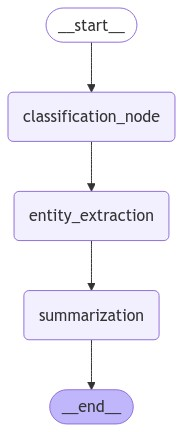

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Testing the Pipeline

In [ ]:
#This cell runs a sample text through our pipeline and displays the results.

In [ ]:
sample_text = """
Post do Linkedin Influencer Samuel Fernando: Quase todos os dias eu recebo mensagem com perguntas do que eu recomendo de cursos e formação em GenAI/LLM.

Eu tenho uma opinião muito forte sobre todos os cursos, imersões e essas coisas de "formação de IA para executivos" oferecidos por influenciadores famosos, .

"""

state_input = {"text": sample_text}
result = llm.invoke([sample_text]).content.strip()

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}